In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


In [3]:
# from google.colab import files
# data_to_load = files.upload()


from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/essec assignment/Forecasting/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
  dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
  #all data reading here  
  df = pd.read_csv(file_path+"Projectdata.csv", date_parser=dateparse)
  df['Datetime'] = pd.to_datetime(df.date, format='%Y-%m-%d')
  df.columns

  column_index_to_pick = 2
  print(df.columns[column_index_to_pick])
  df = df[["Datetime",df.columns[column_index_to_pick]]]

Household_1_CA_1


In [5]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []
    
    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)
    

In [6]:
df = df.set_index(['Datetime'])
df = df.rename(columns={df.columns[0]: 'value'})

df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic:
    df = df.sort_index()
    
plot_dataset(df, title='Walmart sales data')
    

RNNs are a type of neural network architecture which is mainly used to detect patterns in sequential data.LSTMs, a special type of RNNs, were designed to handle such long range dependencies much better than standard RNNs.
Feature engineering for LSTM:
Inorder to give each time series a memory, we create lag parameters for each Y(t), which are the memory of the time series for lag p, this lag is usually identified from -
1. We extract Month, day, day of the week and week of the year variables from the 
datetime of the timeseries and use them as an added feature for our model.
2. We also tried to generate cyclical features for the above generated date parameters and evaluated it for our model.
3. Inorder to add extra features like holidays and snap days, we create two more variables for the same.
4. We use OneHotEncoder to encode all the data before passing to the parameters.
5. It is considered a good practice to scale the data as it is prepared for any Neural Network, we  use MinMaxScaler for this.
6. Our LSTM is a plain Linear model with a single hidden layer and batch size of 32. We train it for 100 epochs and have a dropout of 0.2.
7. In the above vanilla model, we saw that the RMSSE was as close to the Linear Regression model, thus showing much scope of improvement upon added hidden layers to the neural network and modification of other parameters


In [7]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["value"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

input_dim = 30

df_timelags = generate_time_lags(df, input_dim)
df_timelags

,value,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-02-28,62,136.0,121.0,106.0,79.0,82.0,97.0,140.0,137.0,168.0,113.0,80.0,92.0,74.0,102.0,140.0,126.0,89.0,68.0,82.0,82.0,84.0,147.0,178.0,84.0,87.0,59.0,90.0,96.0,104.0,105.0
2011-03-01,86,62.0,136.0,121.0,106.0,79.0,82.0,97.0,140.0,137.0,168.0,113.0,80.0,92.0,74.0,102.0,140.0,126.0,89.0,68.0,82.0,82.0,84.0,147.0,178.0,84.0,87.0,59.0,90.0,96.0,104.0
2011-03-02,82,86.0,62.0,136.0,121.0,106.0,79.0,82.0,97.0,140.0,137.0,168.0,113.0,80.0,92.0,74.0,102.0,140.0,126.0,89.0,68.0,82.0,82.0,84.0,147.0,178.0,84.0,87.0,59.0,90.0,96.0
2011-03-03,97,82.0,86.0,62.0,136.0,121.0,106.0,79.0,82.0,97.0,140.0,137.0,168.0,113.0,80.0,92.0,74.0,102.0,140.0,126.0,89.0,68.0,82.0,82.0,84.0,147.0,178.0,84.0,87.0,59.0,90.0
2011-03-04,82,97.0,82.0,86.0,62.0,136.0,121.0,106.0,79.0,82.0,97.0,140.0,137.0,168.0,113.0,80.0,92.0,74.0,102.0,140.0,126.0,89.0,68.0,82.0,82.0,84.0,147.0,178.0,84.0,87.0,59.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,210,204.0,272.0,401.0,329.0,244.0,193.0,209.0,247.0,246.0,349.0,342.0,262.0,239.0,205.0,228.0,303.0,351.0,270.0,217.0,196.0,193.0,193.0,188.0,314.0,313.0,208.0,193.0,202.0,184.0,230.0
2016-06-16,218,210.0,204.0,272.0,401.0,329.0,244.0,193.0,209.0,247.0,246.0,349.0,342.0,262.0,239.0,205.0,228.0,303.0,351.0,270.0,217.0,196.0,193.0,193.0,188.0,314.0,313.0,208.0,193.0,202.0,184.0
2016-06-17,230,218.0,210.0,204.0,272.0,401.0,329.0,244.0,193.0,209.0,247.0,246.0,349.0,342.0,262.0,239.0,205.0,228.0,303.0,351.0,270.0,217.0,196.0,193.0,193.0,188.0,314.0,313.0,208.0,193.0,202.0


In [8]:
# df_features = (
#                 df
#                 .assign(hour = df.index.hour)
#                 .assign(day = df.index.day)
#                 .assign(month = df.index.month)
#                 .assign(day_of_week = df.index.dayofweek)
#                 .assign(week_of_year = df.index.week)
#               )

# df_features.columns

df_features = (
                df_timelags
                .assign(hour = df_timelags.index.hour)
                .assign(day = df_timelags.index.day)
                .assign(month = df_timelags.index.month)
                .assign(day_of_week = df_timelags.index.dayofweek)
                .assign(week_of_year = df_timelags.index.week)
              )

df_features.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



Index(['value', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8',
       'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16',
       'lag17', 'lag18', 'lag19', 'lag20', 'lag21', 'lag22', 'lag23', 'lag24',
       'lag25', 'lag26', 'lag27', 'lag28', 'lag29', 'lag30', 'hour', 'day',
       'month', 'day_of_week', 'week_of_year'],
      dtype='object')

In [9]:
def onehot_encode_pd(df, cols):
    for col in cols:
        dummies = pd.get_dummies(df[col], prefix=col)
    
    return pd.concat([df, dummies], axis=1).drop(columns=cols)

# df_features2 = onehot_encode_pd(df_features, ['month','day','day_of_week','week_of_year'])
df_features2 = onehot_encode_pd(df_features, ['month'])
df_features2 = onehot_encode_pd(df_features2, ['day'])
df_features2 = onehot_encode_pd(df_features2, ['day_of_week'])
df_features2 = onehot_encode_pd(df_features2, ['week_of_year'])
df_features2.columns

Index(['value', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8',
       'lag9',
       ...
       'week_of_year_44', 'week_of_year_45', 'week_of_year_46',
       'week_of_year_47', 'week_of_year_48', 'week_of_year_49',
       'week_of_year_50', 'week_of_year_51', 'week_of_year_52',
       'week_of_year_53'],
      dtype='object', length=135)

In [10]:
#NOTTT DOING this right now

def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

# df_features = generate_cyclical_features(df_features, 'hour', 24, 0)
# df_features = generate_cyclical_features(df_features, 'day_of_week', 7, 0)
# df_features = generate_cyclical_features(df_features, 'month', 12, 1)
# df_features = generate_cyclical_features(df_features, 'week_of_year', 52, 0)

df_features2.columns



Index(['value', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8',
       'lag9',
       ...
       'week_of_year_44', 'week_of_year_45', 'week_of_year_46',
       'week_of_year_47', 'week_of_year_48', 'week_of_year_49',
       'week_of_year_50', 'week_of_year_51', 'week_of_year_52',
       'week_of_year_53'],
      dtype='object', length=135)

In [11]:
#create holidays from calendar data
calendar_data = pd.read_csv(file_path+"calendar.csv", date_parser=dateparse)
calendar_data['date'] = pd.to_datetime(calendar_data.date, format='%Y-%m-%d')
calendar_data.dtypes
calendar_data["holidays"] = np.where( (calendar_data["event_name_1"].notnull()) | (calendar_data["event_name_2"].notnull()), 1, 0)
calendar_data.head()

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,holidays
0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0,0
4,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1,0


In [12]:
from datetime import date
import holidays

# us_holidays = holidays.US()

def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in calendar_data['date']) else 0

def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday))


df_features2 = add_holiday_col(df_features2, calendar_data[["date","holidays"]])
df_features2.columns
df_features2

,value,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30,hour,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,...,week_of_year_15,week_of_year_16,week_of_year_17,week_of_year_18,week_of_year_19,week_of_year_20,week_of_year_21,week_of_year_22,week_of_year_23,week_of_year_24,week_of_year_25,week_of_year_26,week_of_year_27,week_of_year_28,week_of_year_29,week_of_year_30,week_of_year_31,week_of_year_32,week_of_year_33,week_of_year_34,week_of_year_35,week_of_year_36,week_of_year_37,week_of_year_38,week_of_year_39,week_of_year_40,week_of_year_41,week_of_year_42,week_of_year_43,week_of_year_44,week_of_year_45,week_of_year_46,week_of_year_47,week_of_year_48,week_of_year_49,week_of_year_50,week_of_year_51,week_of_year_52,week_of_year_53,is_holiday
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-02-28,62,136.0,121.0,106.0,79.0,82.0,97.0,140.0,137.0,168.0,113.0,80.0,92.0,74.0,102.0,140.0,126.0,89.0,68.0,82.0,82.0,84.0,147.0,178.0,84.0,87.0,59.0,90.0,96.0,104.0,105.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-03-01,86,62.0,136.0,121.0,106.0,79.0,82.0,97.0,140.0,137.0,168.0,113.0,80.0,92.0,74.0,102.0,140.0,126.0,89.0,68.0,82.0,82.0,84.0,147.0,178.0,84.0,87.0,59.0,90.0,96.0,104.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-03-02,82,86.0,62.0,136.0,121.0,106.0,79.0,82.0,97.0,140.0,137.0,168.0,113.0,80.0,92.0,74.0,102.0,140.0,126.0,89.0,68.0,82.0,82.0,84.0,147.0,178.0,84.0,87.0,59.0,90.0,96.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-03-03,97,82.0,86.0,62.0,136.0,121.0,106.0,79.0,82.0,97.0,140.0,137.0,168.0,113.0,80.0,92.0,74.0,102.0,140.0,126.0,89.0,68.0,82.0,82.0,84.0,147.0,178.0,84.0,87.0,59.0,90.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-03-04,82,97.0,82.0,86.0,62.0,136.0,121.0,106.0,79.0,82.0,97.0,140.0,137.0,168.0,113.0,80.0,92.0,74.0,102.0,140.0,126.0,89.0,68.0,82.0,82.0,84.0,147.0,178.0,84.0,87.0,59.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-15,210,204.0,272.0,401.0,329.0,244.0,193.0,209.0,247.0,246.0,349.0,342.0,262.0,239.0,205.0,228.0,303.0,351.0,270.0,217.0,196.0,193.0,193.0,188.0,314.0,313.0,208.0,193.0,202.0,184.0,230.0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-16,218,210.0,204.0,272.0,401.0,329.0,244.0,193.0,209.0,247.0,246.0,349.0,342.0,262.0,239.0,205.0,228.0,303.0,351.0,270.0,217.0,196.0,193.0,193.0,188.0,314.0,313.0,208.0,193.0,202.0,184.0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-17,230,218.0,210.0,204.0,272.0,401.0,329.0,244.0,193.0,209.0,247.0,246.0,349.0,342.0,262.0,239.0,205.0,228.0,303.0,351.0,270.0,217.0,196.0,193.0,193.0,188.0,314.0,313.0,208.0,193.0,202.0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
df_features2.columns

Index(['value', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8',
       'lag9',
       ...
       'week_of_year_45', 'week_of_year_46', 'week_of_year_47',
       'week_of_year_48', 'week_of_year_49', 'week_of_year_50',
       'week_of_year_51', 'week_of_year_52', 'week_of_year_53', 'is_holiday'],
      dtype='object', length=136)

In [14]:
from sklearn.model_selection import train_test_split

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_features2, 'value', 0.2)

In [15]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [16]:

scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [17]:
X_train.columns

Index(['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9',
       'lag10',
       ...
       'week_of_year_45', 'week_of_year_46', 'week_of_year_47',
       'week_of_year_48', 'week_of_year_49', 'week_of_year_50',
       'week_of_year_51', 'week_of_year_52', 'week_of_year_53', 'is_holiday'],
      dtype='object', length=135)

In [18]:
from torch.utils.data import TensorDataset, DataLoader

# batch_size = 64
batch_size = 32

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

class LSTMModel(nn.Module):

In [39]:
import torch.nn.functional as F
#@title
class LSTMModel(nn.Module):
    """LSTMModel class extends nn.Module class and works as a constructor for LSTMs.

       LSTMModel class initiates a LSTM module based on PyTorch's nn.Module class.
       It has only two methods, namely init() and forward(). While the init()
       method initiates the model with the given input parameters, the forward()
       method defines how the forward propagation needs to be calculated.
       Since PyTorch automatically defines back propagation, there is no need
       to define back propagation method.

       Attributes:
           hidden_dim (int): The number of nodes in each layer
           layer_dim (str): The number of layers in the network
           lstm (nn.LSTM): The LSTM model constructed with the input parameters.
           fc (nn.Linear): The fully connected layer to convert the final state
                           of LSTMs to our desired output shape.

    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        """The __init__ method that initiates a LSTM instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=0.2
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, 30)
        self.relu = nn.ReLU(inplace=True)
        # self.fc1 = nn.Linear(50, 30)
        # self.fc2 = nn.Linear(30, 15)
        self.fc3 = nn.Linear(30, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.relu(self.fc(out))
        # out = self.relu(self.fc1(out))
        # out = self.relu(self.fc2(out))
        out = self.fc3(out)

        return out

In [32]:
def get_model(model, model_params):
    models = {
        "lstm": LSTMModel
    }
    return models.get(model.lower())(**model_params)

class Optimization:
x_batch = x_batch.view([batch_size, -1, n_features]).to(device)

In [46]:
#@title
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = torch.sqrt(self.loss_fn(y, yhat))
        # RMSE_loss.backward()    
        # loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """
        model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/100] Training loss: 0.0430	 Validation loss: 0.0285
[2/100] Training loss: 0.0348	 Validation loss: 0.0240
[3/100] Training loss: 0.0268	 Validation loss: 0.0193
[4/100] Training loss: 0.0250	 Validation loss: 0.0170
[5/100] Training loss: 0.0223	 Validation loss: 0.0154
[6/100] Training loss: 0.0173	 Validation loss: 0.0140
[7/100] Training loss: 0.0139	 Validation loss: 0.0103
[8/100] Training loss: 0.0114	 Validation loss: 0.0090
[9/100] Training loss: 0.0105	 Validation loss: 0.0092
[10/100] Training loss: 0.0109	 Validation loss: 0.0095
[50/100] Training loss: 0.0040	 Validation loss: 0.0080
[100/100] Training loss: 0.0026	 Validation loss: 0.0087


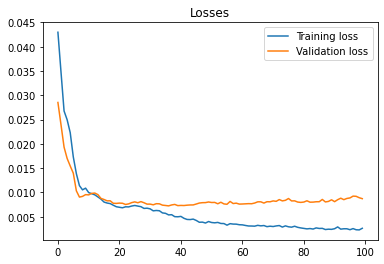

In [24]:
#TESTING if this model works

import torch.optim as optim

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 32
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim}

# model = get_model('lstm', model_params)
model = LSTMModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)

In [25]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)
df_result

,value,prediction
Datetime,,
2015-05-29,200.000000,243.172745
2015-05-30,281.000000,316.746338
2015-05-31,380.000000,350.080536
2015-06-01,272.000000,307.789093
2015-06-02,218.999985,264.456482
...,...,...
2016-06-15,210.000000,208.061234
2016-06-16,217.999985,212.833252
2016-06-17,230.000000,231.400177


In [26]:
!pip install sktime

     |████████████████████████████████| 9.5 MB 4.5 MB/s 
  Using cached numpy-1.19.3-cp37-cp37m-manylinux2010_x86_64.whl (14.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.1
    Uninstalling statsmodels-0.13.1:
      Successfully uninstalled statsmodels-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sktime.performance_metrics.forecasting import mean_squared_scaled_error

def calculate_metrics(df):
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2' : r2_score(df.value, df.prediction),
                      'rmsse': mean_squared_scaled_error(df.value, df.prediction, y_train=y_train, 
                                                         multioutput= 'uniform_average', square_root=True)
                     }
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    print("RMSSE Score:                 ", result_metrics["rmsse"])
    return result_metrics

result_metrics = calculate_metrics(df_result)


Mean Absolute Error:        30.52822
Root Mean Squared Error:    41.38163330748694
R^2 Score:                  0.5958356164637312
RMSSE Score:                  0.8130415261419924


In [28]:
from sklearn.linear_model import LinearRegression

def build_baseline_model(df, test_ratio, target_col):
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    result = pd.DataFrame(y_test)
    result["prediction"] = prediction
    result = result.sort_index()

    return result

df_baseline = build_baseline_model(df_features, 0.2, 'value')
baseline_metrics = calculate_metrics(df_baseline)


Mean Absolute Error:        25.162516159667955
Root Mean Squared Error:    34.417758850704125
R^2 Score:                  0.7204187985066064
RMSSE Score:                  0.6762194951183992


In [29]:
rmsse = {}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.4006	 Validation loss: 0.0710
[2/150] Training loss: 0.1303	 Validation loss: 0.0190
[3/150] Training loss: 0.1464	 Validation loss: 0.0166
[4/150] Training loss: 0.1653	 Validation loss: 0.0140
[5/150] Training loss: 0.1600	 Validation loss: 0.0121
[6/150] Training loss: 0.1476	 Validation loss: 0.0124
[7/150] Training loss: 0.1385	 Validation loss: 0.0130
[8/150] Training loss: 0.1325	 Validation loss: 0.0139
[9/150] Training loss: 0.1328	 Validation loss: 0.0133
[10/150] Training loss: 0.1261	 Validation loss: 0.0130
[50/150] Training loss: 0.0610	 Validation loss: 0.0072
[100/150] Training loss: 0.0407	 Validation loss: 0.0080
[150/150] Training loss: 0.0440	 Validation loss: 0.0092


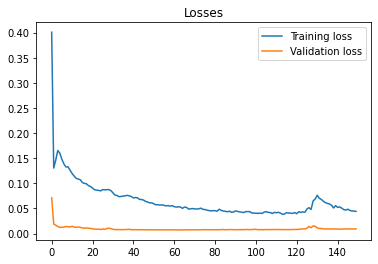

Mean Absolute Error:        30.71975
Root Mean Squared Error:    40.29090688647223
R^2 Score:                  0.6156343390109988
RMSSE Score:                  0.7965365350851297


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.2232	 Validation loss: 0.0242
[2/150] Training loss: 0.1397	 Validation loss: 0.0245
[3/150] Training loss: 0.1264	 Validation loss: 0.0166
[4/150] Training loss: 0.1132	 Validation loss: 0.0098
[5/150] Training loss: 0.1029	 Validation loss: 0.0098
[6/150] Training loss: 0.0982	 Validation loss: 0.0090
[7/150] Training loss: 0.0982	 Validation loss: 0.0087
[8/150] Training loss: 0.0970	 Validation loss: 0.0084
[9/150] Training loss: 0.0989	 Validation loss: 0.0088
[10/150] Training loss: 0.0958	 Validation loss: 0.0090
[50/150] Training loss: 0.0753	 Validation loss: 0.0095
[100/150] Training loss: 0.0460	 Validation loss: 0.0100
[150/150] Training loss: 0.0322	 Validation loss: 0.0102


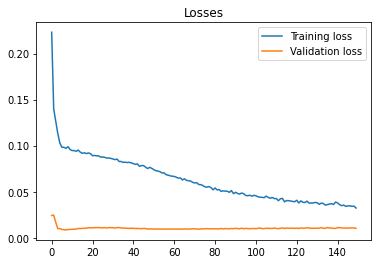

Mean Absolute Error:        17.650381
Root Mean Squared Error:    22.843382617172335
R^2 Score:                  0.4667755707772848
RMSSE Score:                  0.8503918058375421


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.5063	 Validation loss: 0.0582
[2/150] Training loss: 0.1379	 Validation loss: 0.0197
[3/150] Training loss: 0.1099	 Validation loss: 0.0157
[4/150] Training loss: 0.0962	 Validation loss: 0.0160
[5/150] Training loss: 0.0925	 Validation loss: 0.0175
[6/150] Training loss: 0.0934	 Validation loss: 0.0187
[7/150] Training loss: 0.0933	 Validation loss: 0.0164
[8/150] Training loss: 0.0906	 Validation loss: 0.0176
[9/150] Training loss: 0.0916	 Validation loss: 0.0158
[10/150] Training loss: 0.0913	 Validation loss: 0.0143
[50/150] Training loss: 0.0730	 Validation loss: 0.0144
[100/150] Training loss: 0.0538	 Validation loss: 0.0125
[150/150] Training loss: 0.0424	 Validation loss: 0.0124


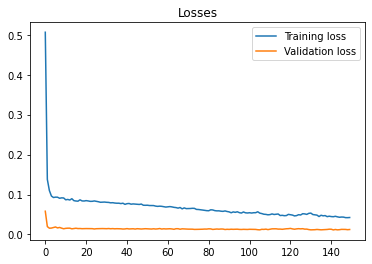

Mean Absolute Error:        30.113546
Root Mean Squared Error:    38.22778153712297
R^2 Score:                  0.10219742213467864
RMSSE Score:                  1.0953491320935562


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.1269	 Validation loss: 0.0111
[2/150] Training loss: 0.1201	 Validation loss: 0.0078
[3/150] Training loss: 0.1116	 Validation loss: 0.0076
[4/150] Training loss: 0.1090	 Validation loss: 0.0068
[5/150] Training loss: 0.0998	 Validation loss: 0.0070
[6/150] Training loss: 0.0990	 Validation loss: 0.0073
[7/150] Training loss: 0.0920	 Validation loss: 0.0065
[8/150] Training loss: 0.0854	 Validation loss: 0.0053
[9/150] Training loss: 0.0843	 Validation loss: 0.0055
[10/150] Training loss: 0.0807	 Validation loss: 0.0050
[50/150] Training loss: 0.0423	 Validation loss: 0.0034
[100/150] Training loss: 0.0313	 Validation loss: 0.0037
[150/150] Training loss: 0.0265	 Validation loss: 0.0047


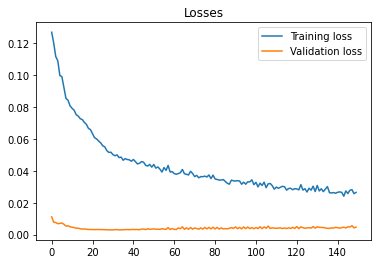

Mean Absolute Error:        46.076878
Root Mean Squared Error:    60.84102138206179
R^2 Score:                  0.3809660060572748
RMSSE Score:                  0.6793413772516582


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.4270	 Validation loss: 0.0432
[2/150] Training loss: 0.1289	 Validation loss: 0.0108
[3/150] Training loss: 0.1233	 Validation loss: 0.0065
[4/150] Training loss: 0.1117	 Validation loss: 0.0040
[5/150] Training loss: 0.1039	 Validation loss: 0.0038
[6/150] Training loss: 0.0973	 Validation loss: 0.0038
[7/150] Training loss: 0.0995	 Validation loss: 0.0037
[8/150] Training loss: 0.1003	 Validation loss: 0.0037
[9/150] Training loss: 0.1057	 Validation loss: 0.0048
[10/150] Training loss: 0.1145	 Validation loss: 0.0091
[50/150] Training loss: 0.0572	 Validation loss: 0.0033
[100/150] Training loss: 0.0380	 Validation loss: 0.0035
[150/150] Training loss: 0.0312	 Validation loss: 0.0033


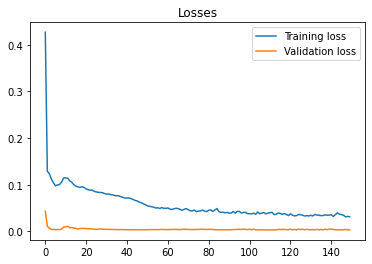

Mean Absolute Error:        139.80727
Root Mean Squared Error:    182.07934182314588
R^2 Score:                  0.7778183196790518
RMSSE Score:                  0.47509861906261946


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.4192	 Validation loss: 0.0154
[2/150] Training loss: 0.1590	 Validation loss: 0.0312
[3/150] Training loss: 0.1398	 Validation loss: 0.0313
[4/150] Training loss: 0.1290	 Validation loss: 0.0300
[5/150] Training loss: 0.1213	 Validation loss: 0.0295
[6/150] Training loss: 0.1171	 Validation loss: 0.0324
[7/150] Training loss: 0.1159	 Validation loss: 0.0316
[8/150] Training loss: 0.1157	 Validation loss: 0.0309
[9/150] Training loss: 0.1184	 Validation loss: 0.0284
[10/150] Training loss: 0.1200	 Validation loss: 0.0275
[50/150] Training loss: 0.1082	 Validation loss: 0.0100
[100/150] Training loss: 0.0653	 Validation loss: 0.0175
[150/150] Training loss: 0.0659	 Validation loss: 0.0119


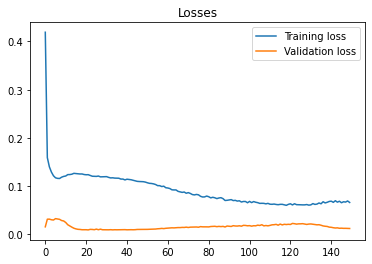

Mean Absolute Error:        56.310024
Root Mean Squared Error:    72.8514112766527
R^2 Score:                  0.12784109197059879
RMSSE Score:                  0.9132461281046284


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.2672	 Validation loss: 0.0391
[2/150] Training loss: 0.1881	 Validation loss: 0.0275
[3/150] Training loss: 0.1699	 Validation loss: 0.0300
[4/150] Training loss: 0.1565	 Validation loss: 0.0309
[5/150] Training loss: 0.1447	 Validation loss: 0.0288
[6/150] Training loss: 0.1340	 Validation loss: 0.0272
[7/150] Training loss: 0.1293	 Validation loss: 0.0251
[8/150] Training loss: 0.1235	 Validation loss: 0.0243
[9/150] Training loss: 0.1190	 Validation loss: 0.0230
[10/150] Training loss: 0.1147	 Validation loss: 0.0214
[50/150] Training loss: 0.0693	 Validation loss: 0.0075
[100/150] Training loss: 0.0449	 Validation loss: 0.0073
[150/150] Training loss: 0.0361	 Validation loss: 0.0067


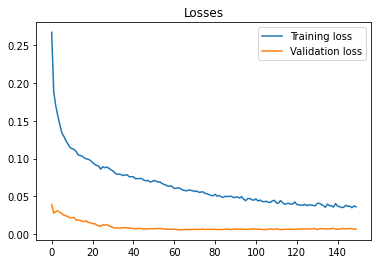

Mean Absolute Error:        38.625675
Root Mean Squared Error:    51.74260920577812
R^2 Score:                  0.5727171113538361
RMSSE Score:                  0.8739190454853121


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.6281	 Validation loss: 0.2344
[2/150] Training loss: 0.2110	 Validation loss: 0.0247
[3/150] Training loss: 0.1355	 Validation loss: 0.0153
[4/150] Training loss: 0.1057	 Validation loss: 0.0121
[5/150] Training loss: 0.0970	 Validation loss: 0.0120
[6/150] Training loss: 0.0980	 Validation loss: 0.0112
[7/150] Training loss: 0.0919	 Validation loss: 0.0129
[8/150] Training loss: 0.0943	 Validation loss: 0.0112
[9/150] Training loss: 0.0932	 Validation loss: 0.0107
[10/150] Training loss: 0.0899	 Validation loss: 0.0119
[50/150] Training loss: 0.0856	 Validation loss: 0.0163
[100/150] Training loss: 0.0678	 Validation loss: 0.0144
[150/150] Training loss: 0.0455	 Validation loss: 0.0112


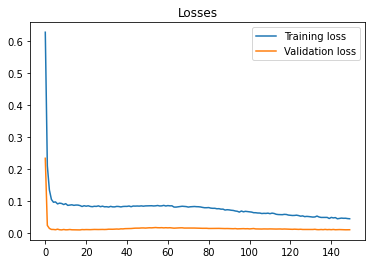

Mean Absolute Error:        26.757828
Root Mean Squared Error:    35.68136645518743
R^2 Score:                  0.5852799076688981
RMSSE Score:                  0.8277853341897083


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.3588	 Validation loss: 0.0297
[2/150] Training loss: 0.1381	 Validation loss: 0.0132
[3/150] Training loss: 0.1152	 Validation loss: 0.0120
[4/150] Training loss: 0.1085	 Validation loss: 0.0112
[5/150] Training loss: 0.1038	 Validation loss: 0.0110
[6/150] Training loss: 0.1021	 Validation loss: 0.0112
[7/150] Training loss: 0.1006	 Validation loss: 0.0113
[8/150] Training loss: 0.1005	 Validation loss: 0.0115
[9/150] Training loss: 0.0989	 Validation loss: 0.0112
[10/150] Training loss: 0.0984	 Validation loss: 0.0114
[50/150] Training loss: 0.0825	 Validation loss: 0.0110
[100/150] Training loss: 0.0566	 Validation loss: 0.0123
[150/150] Training loss: 0.0424	 Validation loss: 0.0136


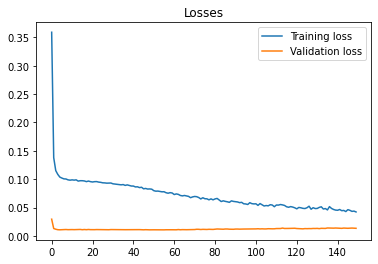

Mean Absolute Error:        75.91845
Root Mean Squared Error:    88.57001997007791
R^2 Score:                  -1.7240933724692944
RMSSE Score:                  6.483449980559171


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.2162	 Validation loss: 0.0138
[2/150] Training loss: 0.1205	 Validation loss: 0.0105
[3/150] Training loss: 0.1168	 Validation loss: 0.0092
[4/150] Training loss: 0.1078	 Validation loss: 0.0075
[5/150] Training loss: 0.0996	 Validation loss: 0.0068
[6/150] Training loss: 0.0983	 Validation loss: 0.0068
[7/150] Training loss: 0.0976	 Validation loss: 0.0066
[8/150] Training loss: 0.0966	 Validation loss: 0.0065
[9/150] Training loss: 0.0950	 Validation loss: 0.0065
[10/150] Training loss: 0.0952	 Validation loss: 0.0066
[50/150] Training loss: 0.0700	 Validation loss: 0.0059
[100/150] Training loss: 0.0436	 Validation loss: 0.0065
[150/150] Training loss: 0.0321	 Validation loss: 0.0072


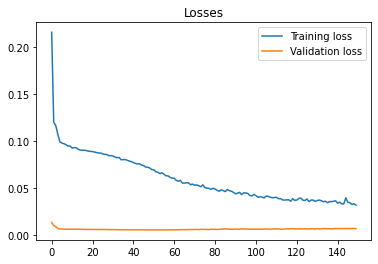

Mean Absolute Error:        41.92242
Root Mean Squared Error:    53.90276936226816
R^2 Score:                  0.3888869968216514
RMSSE Score:                  1.1805376830269405


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.2986	 Validation loss: 0.0154
[2/150] Training loss: 0.1246	 Validation loss: 0.0172
[3/150] Training loss: 0.1122	 Validation loss: 0.0128
[4/150] Training loss: 0.0955	 Validation loss: 0.0090
[5/150] Training loss: 0.0878	 Validation loss: 0.0074
[6/150] Training loss: 0.0813	 Validation loss: 0.0095
[7/150] Training loss: 0.0861	 Validation loss: 0.0081
[8/150] Training loss: 0.0848	 Validation loss: 0.0086
[9/150] Training loss: 0.0852	 Validation loss: 0.0094
[10/150] Training loss: 0.0848	 Validation loss: 0.0110
[50/150] Training loss: 0.0686	 Validation loss: 0.0113
[100/150] Training loss: 0.0376	 Validation loss: 0.0042
[150/150] Training loss: 0.0334	 Validation loss: 0.0045


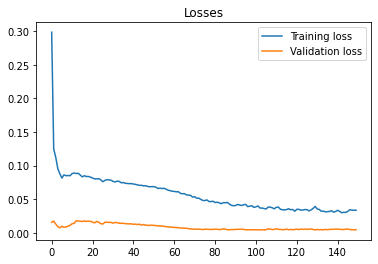

Mean Absolute Error:        172.25467
Root Mean Squared Error:    236.24104645732078
R^2 Score:                  0.6182489140941902
RMSSE Score:                  1.0278460371569509


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.5181	 Validation loss: 0.1443
[2/150] Training loss: 0.1447	 Validation loss: 0.0195
[3/150] Training loss: 0.1229	 Validation loss: 0.0124
[4/150] Training loss: 0.1104	 Validation loss: 0.0128
[5/150] Training loss: 0.1129	 Validation loss: 0.0135
[6/150] Training loss: 0.1158	 Validation loss: 0.0143
[7/150] Training loss: 0.1189	 Validation loss: 0.0165
[8/150] Training loss: 0.1227	 Validation loss: 0.0164
[9/150] Training loss: 0.1262	 Validation loss: 0.0150
[10/150] Training loss: 0.1274	 Validation loss: 0.0129
[50/150] Training loss: 0.0962	 Validation loss: 0.0112
[100/150] Training loss: 0.0616	 Validation loss: 0.0160
[150/150] Training loss: 0.0428	 Validation loss: 0.0185


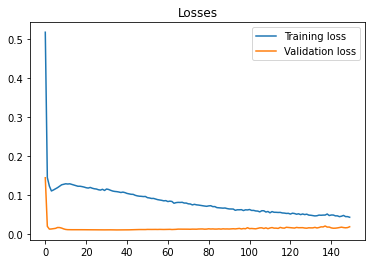

Mean Absolute Error:        77.03589
Root Mean Squared Error:    98.03896008889782
R^2 Score:                  -0.18009320897439074
RMSSE Score:                  1.182396762207118


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.3824	 Validation loss: 0.0427
[2/150] Training loss: 0.1405	 Validation loss: 0.0174
[3/150] Training loss: 0.1575	 Validation loss: 0.0191
[4/150] Training loss: 0.1691	 Validation loss: 0.0132
[5/150] Training loss: 0.1561	 Validation loss: 0.0122
[6/150] Training loss: 0.1512	 Validation loss: 0.0116
[7/150] Training loss: 0.1454	 Validation loss: 0.0115
[8/150] Training loss: 0.1415	 Validation loss: 0.0121
[9/150] Training loss: 0.1371	 Validation loss: 0.0128
[10/150] Training loss: 0.1332	 Validation loss: 0.0124
[50/150] Training loss: 0.0718	 Validation loss: 0.0077
[100/150] Training loss: 0.0472	 Validation loss: 0.0091
[150/150] Training loss: 0.0394	 Validation loss: 0.0101


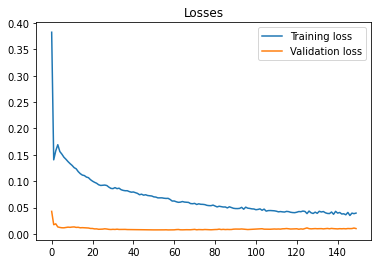

Mean Absolute Error:        50.816624
Root Mean Squared Error:    66.92918000931095
R^2 Score:                  0.4231069107675576
RMSSE Score:                  1.0230286365663384


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.3484	 Validation loss: 0.0265
[2/150] Training loss: 0.1374	 Validation loss: 0.0168
[3/150] Training loss: 0.1161	 Validation loss: 0.0131
[4/150] Training loss: 0.1059	 Validation loss: 0.0102
[5/150] Training loss: 0.0996	 Validation loss: 0.0097
[6/150] Training loss: 0.0990	 Validation loss: 0.0095
[7/150] Training loss: 0.0961	 Validation loss: 0.0096
[8/150] Training loss: 0.0962	 Validation loss: 0.0096
[9/150] Training loss: 0.0946	 Validation loss: 0.0098
[10/150] Training loss: 0.0947	 Validation loss: 0.0097
[50/150] Training loss: 0.0862	 Validation loss: 0.0108
[100/150] Training loss: 0.0519	 Validation loss: 0.0105
[150/150] Training loss: 0.0407	 Validation loss: 0.0111


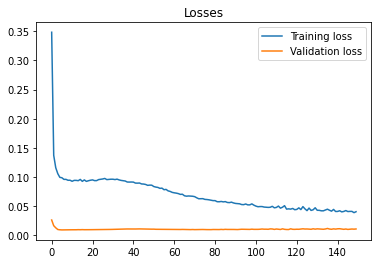

Mean Absolute Error:        24.997612
Root Mean Squared Error:    31.670805436429738
R^2 Score:                  0.47171710421926316
RMSSE Score:                  0.8626254183301303


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.4329	 Validation loss: 0.0120
[2/150] Training loss: 0.1141	 Validation loss: 0.0195
[3/150] Training loss: 0.1011	 Validation loss: 0.0128
[4/150] Training loss: 0.0918	 Validation loss: 0.0118
[5/150] Training loss: 0.0894	 Validation loss: 0.0107
[6/150] Training loss: 0.0875	 Validation loss: 0.0096
[7/150] Training loss: 0.0835	 Validation loss: 0.0103
[8/150] Training loss: 0.0846	 Validation loss: 0.0097
[9/150] Training loss: 0.0835	 Validation loss: 0.0091
[10/150] Training loss: 0.0821	 Validation loss: 0.0094
[50/150] Training loss: 0.0699	 Validation loss: 0.0098
[100/150] Training loss: 0.0525	 Validation loss: 0.0085
[150/150] Training loss: 0.0400	 Validation loss: 0.0089


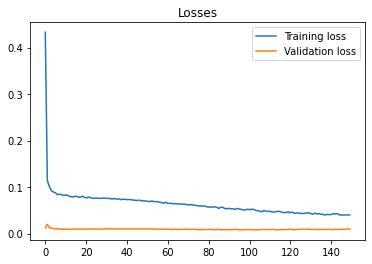

Mean Absolute Error:        35.546352
Root Mean Squared Error:    44.02473170790624
R^2 Score:                  0.07512270776340757
RMSSE Score:                  1.0433096445921504


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.4052	 Validation loss: 0.0090
[2/150] Training loss: 0.1590	 Validation loss: 0.0119
[3/150] Training loss: 0.1543	 Validation loss: 0.0068
[4/150] Training loss: 0.1501	 Validation loss: 0.0058
[5/150] Training loss: 0.1436	 Validation loss: 0.0061
[6/150] Training loss: 0.1359	 Validation loss: 0.0067
[7/150] Training loss: 0.1249	 Validation loss: 0.0087
[8/150] Training loss: 0.1162	 Validation loss: 0.0094
[9/150] Training loss: 0.1124	 Validation loss: 0.0096
[10/150] Training loss: 0.1102	 Validation loss: 0.0090
[50/150] Training loss: 0.0650	 Validation loss: 0.0040
[100/150] Training loss: 0.0476	 Validation loss: 0.0049
[150/150] Training loss: 0.0470	 Validation loss: 0.0065


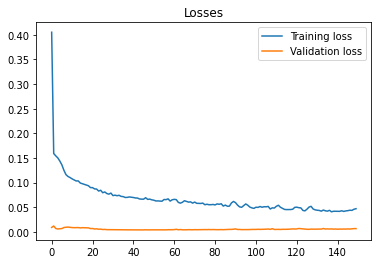

Mean Absolute Error:        66.929436
Root Mean Squared Error:    85.19937841340892
R^2 Score:                  0.21827056739025164
RMSSE Score:                  0.7406501135825783


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



[1/150] Training loss: 0.4321	 Validation loss: 0.1152
[2/150] Training loss: 0.1100	 Validation loss: 0.0145
[3/150] Training loss: 0.1290	 Validation loss: 0.0070
[4/150] Training loss: 0.1107	 Validation loss: 0.0054
[5/150] Training loss: 0.1035	 Validation loss: 0.0049
[6/150] Training loss: 0.1014	 Validation loss: 0.0041
[7/150] Training loss: 0.0962	 Validation loss: 0.0042
[8/150] Training loss: 0.0950	 Validation loss: 0.0040
[9/150] Training loss: 0.0921	 Validation loss: 0.0041
[10/150] Training loss: 0.0921	 Validation loss: 0.0039
[50/150] Training loss: 0.0524	 Validation loss: 0.0030
[100/150] Training loss: 0.0407	 Validation loss: 0.0027
[150/150] Training loss: 0.0324	 Validation loss: 0.0039


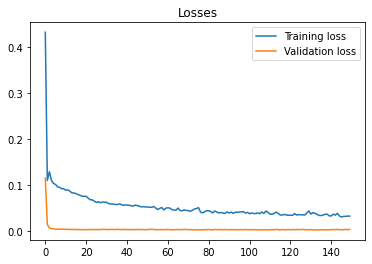

Mean Absolute Error:        234.98839
Root Mean Squared Error:    291.98553849035056
R^2 Score:                  0.49995962307712816
RMSSE Score:                  0.7388000556176572


In [56]:
for column_index_to_pick in range(2,19):
  dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')
  #all data reading here  
  df = pd.read_csv(file_path+"Projectdata.csv", date_parser=dateparse)
  df['Datetime'] = pd.to_datetime(df.date, format='%Y-%m-%d')
  # df.columns

  # column_index_to_pick = 1
  column_name = df.columns[column_index_to_pick]
  df = df[["Datetime",df.columns[column_index_to_pick]]]

  df = df.set_index(['Datetime'])
  df = df.rename(columns={df.columns[0]: 'value'})

  df.index = pd.to_datetime(df.index)
  if not df.index.is_monotonic:
      df = df.sort_index()

  input_dim = 7
  df_timelags = generate_time_lags(df, input_dim)

  df_features = (
                  df_timelags
                  .assign(hour = df_timelags.index.hour)
                  .assign(day = df_timelags.index.day)
                  .assign(month = df_timelags.index.month)
                  .assign(day_of_week = df_timelags.index.dayofweek)
                  .assign(week_of_year = df_timelags.index.week)
                )
  # df_features.columns

  df_features2 = onehot_encode_pd(df_features, ['month'])
  df_features2 = onehot_encode_pd(df_features2, ['day'])
  df_features2 = onehot_encode_pd(df_features2, ['day_of_week'])
  df_features2 = onehot_encode_pd(df_features2, ['week_of_year'])
  # df_features2.columns

  calendar_data = pd.read_csv(file_path+"calendar.csv", date_parser=dateparse)
  calendar_data['date'] = pd.to_datetime(calendar_data.date, format='%Y-%m-%d')
  # calendar_data.dtypes
  calendar_data["holidays"] = np.where( (calendar_data["event_name_1"].notnull()) | (calendar_data["event_name_2"].notnull()), 1, 0)
  # calendar_data.head()

  df_features2 = add_holiday_col(df_features2, calendar_data[["date","holidays"]])
  # df_features2.columns
  # df_features2

  X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_features2, 'value', 0.2)

  scaler = get_scaler('minmax')
  X_train_arr = scaler.fit_transform(X_train)
  X_val_arr = scaler.transform(X_val)
  X_test_arr = scaler.transform(X_test)

  y_train_arr = scaler.fit_transform(y_train)
  y_val_arr = scaler.transform(y_val)
  y_test_arr = scaler.transform(y_test)

  from torch.utils.data import TensorDataset, DataLoader

  # batch_size = 64
  batch_size = 32

  train_features = torch.Tensor(X_train_arr)
  train_targets = torch.Tensor(y_train_arr)
  val_features = torch.Tensor(X_val_arr)
  val_targets = torch.Tensor(y_val_arr)
  test_features = torch.Tensor(X_test_arr)
  test_targets = torch.Tensor(y_test_arr)

  train = TensorDataset(train_features, train_targets)
  val = TensorDataset(val_features, val_targets)
  test = TensorDataset(test_features, test_targets)

  train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
  val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
  test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
  test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

  input_dim = len(X_train.columns)
  output_dim = 1
  hidden_dim = 64
  layer_dim = 3
  batch_size = 32
  dropout = 0.2
  n_epochs = 150
  learning_rate = 1e-3
  weight_decay = 1e-6

  model_params = {'input_dim': input_dim,
                  'hidden_dim' : hidden_dim,
                  'layer_dim' : layer_dim,
                  'output_dim' : output_dim}

  model = get_model('lstm', model_params)

  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


  opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
  opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
  opt.plot_losses()

  predictions, values = opt.evaluate(
      test_loader_one,
      batch_size=1,
      n_features=input_dim
  )


  df_result = format_predictions(predictions, values, X_test, scaler)
  result_metrics = calculate_metrics(df_result)
  rmsse[column_name] = result_metrics["rmsse"]

In [57]:
print(rmsse)

# {'Hobbies_CA_1': 0.7656939042398, 'Household_1_CA_1': 0.7965365350851297, 'Household_2_CA_1': 0.8503918058375421, 
#  'Foods_1_CA_1': 1.0953491320935562, 'Foods_2_CA_1': 0.6793413772516582, 'Foods_3_CA_1': 0.47509861906261946, 
#  'Hobbies_CA_2': 0.9132461281046284, 'Household_1_CA_2': 0.8739190454853121, 'Household_2_CA_2': 0.8277853341897083, 
#  'Foods_1_CA_2': 6.483449980559171, 'Foods_2_CA_2': 1.1805376830269405, 'Foods_3_CA_2': 1.0278460371569509, 
#  'Hobbies_CA_3': 1.182396762207118, 'Household_1_CA_3': 1.0230286365663384, 'Household_2_CA_3': 0.8626254183301303,
#  'Foods_1_CA_3': 1.0433096445921504, 'Foods_2_CA_3': 0.7406501135825783, 'Foods_3_CA_3': 0.7388000556176572}


{'Hobbies_CA_1': 0.7656939042398, 'Household_1_CA_1': 0.7965365350851297, 'Household_2_CA_1': 0.8503918058375421, 'Foods_1_CA_1': 1.0953491320935562, 'Foods_2_CA_1': 0.6793413772516582, 'Foods_3_CA_1': 0.47509861906261946, 'Hobbies_CA_2': 0.9132461281046284, 'Household_1_CA_2': 0.8739190454853121, 'Household_2_CA_2': 0.8277853341897083, 'Foods_1_CA_2': 6.483449980559171, 'Foods_2_CA_2': 1.1805376830269405, 'Foods_3_CA_2': 1.0278460371569509, 'Hobbies_CA_3': 1.182396762207118, 'Household_1_CA_3': 1.0230286365663384, 'Household_2_CA_3': 0.8626254183301303, 'Foods_1_CA_3': 1.0433096445921504, 'Foods_2_CA_3': 0.7406501135825783, 'Foods_3_CA_3': 0.7388000556176572}
